In [181]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

titanic_train_df = pd.read_csv('train.csv')
titanic_test_df = pd.read_csv('test.csv')

In [182]:
titanic_train_df.info()
titanic_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

In [183]:
def metrics(y_val, y_pred_val):
    val_accuracy = accuracy_score(y_val, y_pred_val)
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    val_recall = recall_score(y_val, y_pred_val)
    print(f"Recall Score: {val_recall:.4f}")

    val_precision = precision_score(y_val, y_pred_val)
    print(f"Precision Score: {val_precision:.4f}")

    val_f1 = f1_score(y_val, y_pred_val)
    print(f"F1 Score: {val_f1:.4f}")

Удалите все пропущенные значения и категориальные переменные. Обучите модель. Выберете и посчитайте метрику качества.

In [184]:
titanic_train_df_1 = titanic_train_df.copy()
titanic_test_df_1 = titanic_test_df.copy()

for df in [titanic_train_df_1, titanic_test_df_1]:
    df.dropna(inplace=True)

numeric_cols_train = titanic_train_df_1.select_dtypes(include=['number']).columns.tolist()
numeric_cols_test = titanic_test_df_1.select_dtypes(include=['number']).columns.tolist()

X = titanic_train_df_1[numeric_cols_train].drop('Survived', axis=1)
y = titanic_train_df_1['Survived']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = LogisticRegression(max_iter=10000, random_state=42)
model.fit(X_train, y_train)
y_pred_val = model.predict(X_val)

metrics(y_val, y_pred_val)

Validation Accuracy: 0.6757
Recall Score: 0.8800
Precision Score: 0.7097
F1 Score: 0.7857


Удалите признаки, которые логически не нужны для построения модели. Обоснуйте.
Проверьте данные на наличие пропущенных значений.
a) Посчитайте, какой процент данных будет потерян, если просто удалить пропуски.
b) Заполните пропуски: средним значением; константой; классом, указывающим на то, что значение было пропущено; случайным числом. Для разных признаков используйте подходящий метод. Можно не использовать все перечисленные методы.

In [185]:
def nulls_filler(df, feature, options=('mean', 'const', 'rand')):
    df = df.copy()

    if options == 'mean':
        df[feature] = df.groupby(df.columns.drop(feature).to_list())[feature].transform('mean')
        if df[feature].isnull().any():
            df[feature] = df[feature].fillna(df[feature].mean())

    elif options == 'const':
        df[feature] = df[feature].fillna(42)
    elif options == 'rand':
        df[feature] = df[feature].fillna(np.random)
    else:
        df[feature] = df[feature].fillna('value_missed')

    return df

In [186]:
titanic_train_df_2 = titanic_train_df.copy()

titanic_train_df_2.head()
X = titanic_train_df_2.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1)
y = titanic_train_df_2['Survived']

data_miss_pct = (X.isnull().sum() / len(X)) * 100
print("Процент потери данных: ", data_miss_pct)

X['Embarked'] = X['Embarked'].fillna(X['Embarked'].mode()[0])
X = nulls_filler(X, 'Age', options='mean')
X.info()

Процент потери данных:  Pclass       0.000000
Sex          0.000000
Age         19.865320
SibSp        0.000000
Parch        0.000000
Fare         0.000000
Embarked     0.224467
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       891 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  891 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 48.9+ KB


Категориальные переменные переведите в цифровые значения

In [187]:
X = pd.get_dummies(X, columns=['Sex', 'Embarked'], drop_first=True)
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,3,22.000000,1,0,7.2500,True,False,True
1,1,38.000000,1,0,71.2833,False,False,False
2,3,25.333333,0,0,7.9250,False,False,True
3,1,34.000000,1,0,53.1000,False,False,True
4,3,30.706897,0,0,8.0500,True,False,True


Проверьте данные на наличие выбросов.
Удалите выбросы, если считаете это целесообразным. Обоснуйте.

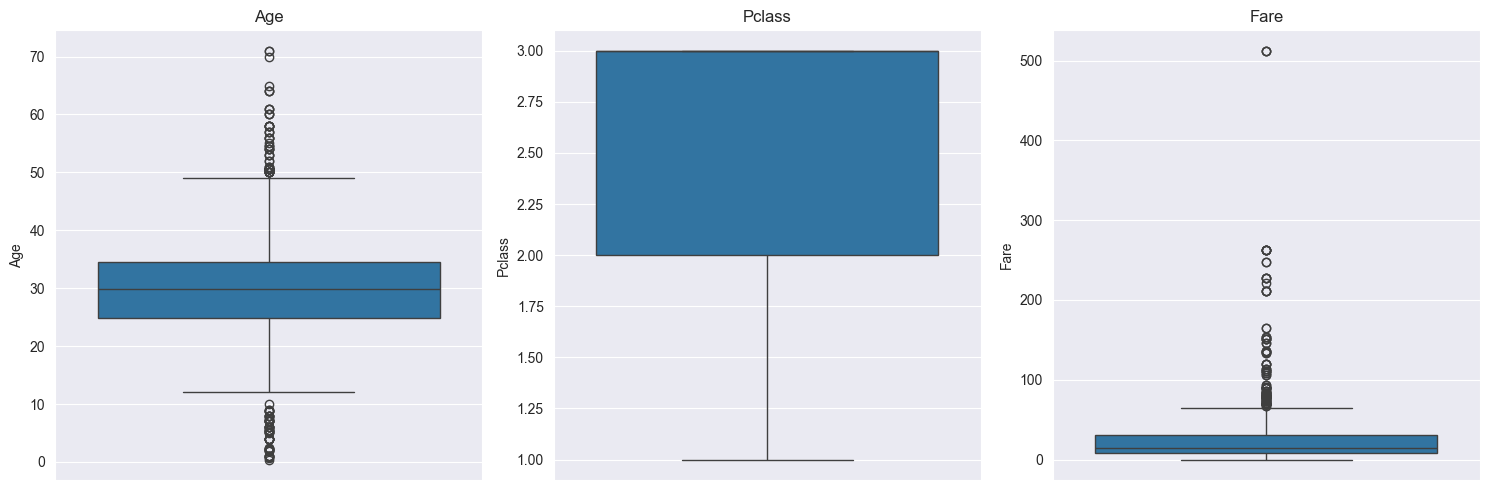

In [188]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, feature in enumerate(['Age', 'Pclass', 'Fare']):
    sns.boxplot(y=X[feature], ax=axes[i])
    axes[i].set_title(f'{feature}')

plt.tight_layout()
plt.show()

<Axes: >

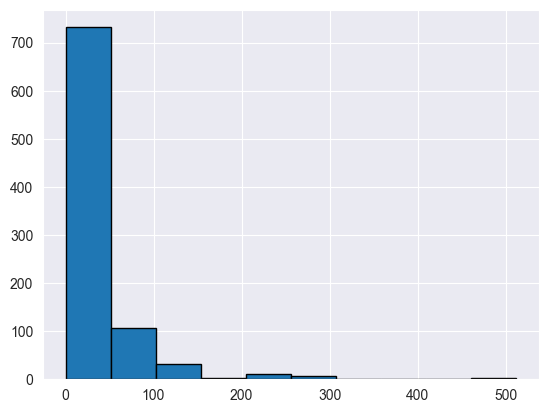

In [189]:
X['Fare'].hist(bins=10, edgecolor='k')